<a href="https://colab.research.google.com/github/majavk/Data_Science_Portfolio/blob/main/deep_net_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  after removing the cwd from sys.path.


In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data

In [ ]:
path = '../DATA'

In [ ]:
df_train = pd.read_csv(path + 'train_features_nn.csv')
df_test = pd.read_csv(path + 'test_features_nn.csv')

In [ ]:
df_train = df_train[['SalePrice', 'LotFrontage', 'OverallQual',
       'TotalBsmtSF', 'GrLivArea', 'GarageArea']]
df_test = df_test[['Id','LotFrontage', 'OverallQual',
       'TotalBsmtSF', 'GrLivArea', 'GarageArea']]

In [ ]:
df_train = df_train[df_train['SalePrice'] < 400000 ]

In [ ]:
df_train.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
SalePrice,1429.0,174882.095171,65989.933775,34900.0,129500.0,160200.000000,209500.0,395192.0
LotFrontage,1429.0,70.071923,21.067929,21.0,60.0,70.083333,80.0,313.0
OverallQual,1429.0,6.035689,1.318151,1.0,5.0,6.000000,7.0,10.0
TotalBsmtSF,1429.0,1035.011197,392.608584,0.0,793.0,980.000000,1268.0,3206.0
GrLivArea,1429.0,1485.365990,471.439138,334.0,1125.0,1453.000000,1750.0,3493.0


In [ ]:
df_train.describe().transpose()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
SalePrice,174882.095171,65989.933775,34900.0,395192.0
LotFrontage,70.071923,21.067929,21.0,313.0
OverallQual,6.035689,1.318151,1.0,10.0
TotalBsmtSF,1035.011197,392.608584,0.0,3206.0
GrLivArea,1485.365990,471.439138,334.0,3493.0
GarageArea,465.199440,207.610681,0.0,1390.0


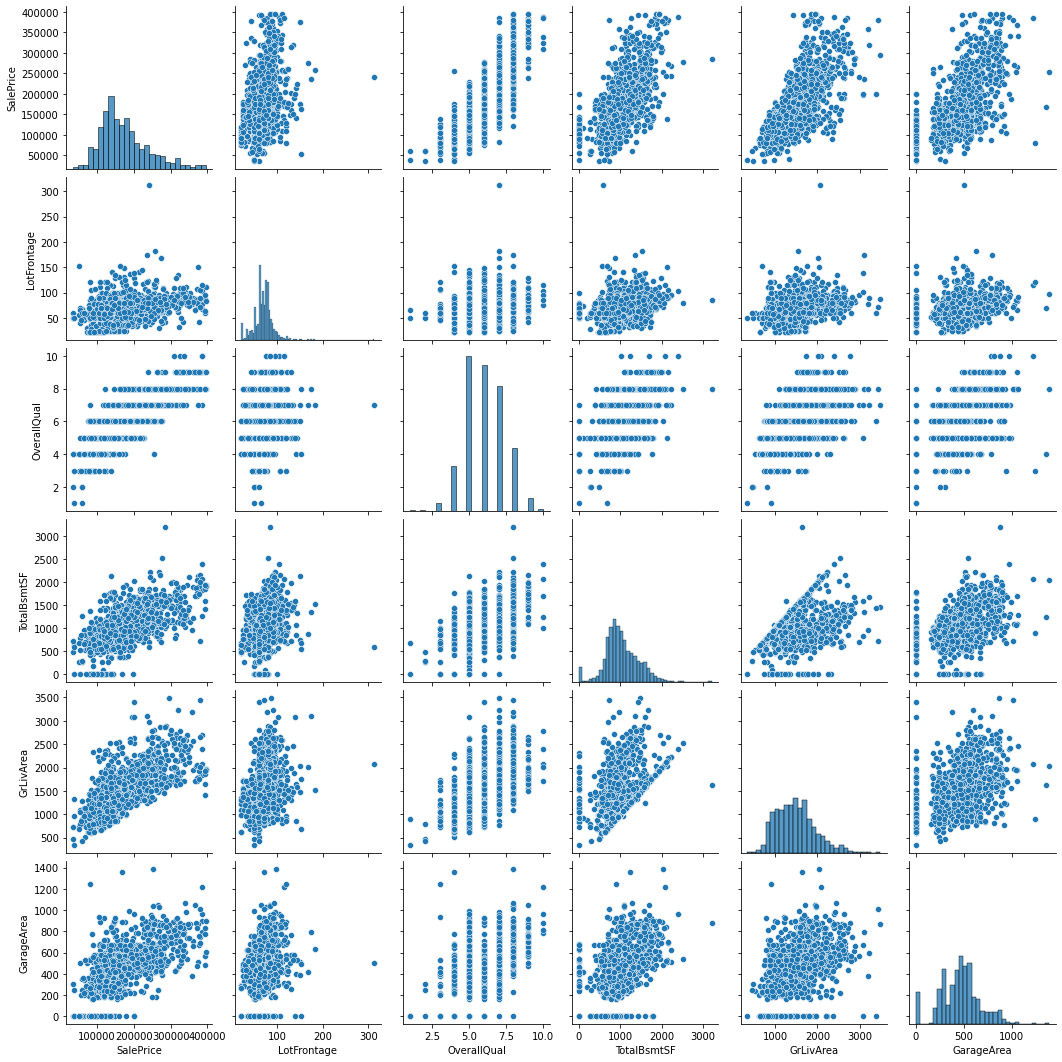

In [ ]:
sns.pairplot(df_train)

##Train and Validation Data Split


In [ ]:
X_train = df_train.sample(frac=0.8, random_state=100)
X_validation = df_train.drop(X_train.index)
X_test = df_test.drop('Id',axis=1)

In [ ]:
print(f"test size: {X_test.shape} \n train size: {X_train.shape} \n {X_validation.shape} ")

test size: (1459, 5) 
 train size: (1143, 6) 
 (286, 6) 


In [ ]:
train_features = X_train.copy()
validation_features = X_validation.copy()

train_labels = train_features.pop('SalePrice')
validation_labels = validation_features.pop('SalePrice')


In [ ]:
print(train_features.shape)
print(validation_features.shape)
print(train_labels.shape)
print(validation_labels.shape)

(1143, 5)
(286, 5)
(1143,)
(286,)


##Normalization

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[  69.89834     6.045494 1036.229    1476.7523    461.17682 ]]


#Linear Regression

In [ ]:
overallqual = np.array(train_features['OverallQual'])

overallqual_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
overallqual_normalizer.adapt(overallqual)

##Keras Sequential Model with only one feature

In [ ]:
overallqual_model = tf.keras.Sequential([
    overallqual_normalizer,
    tf.keras.layers.Dense(units=1)
])

overallqual_model.summary()

overallqual_model.compile(optimizer='adam',loss='mse')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
overallqual_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                          loss='mean_absolute_error')
          

In [ ]:
%%time
history = overallqual_model.fit(
    train_features['OverallQual'],
    train_labels,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

CPU times: user 1min 4s, sys: 3.63 s, total: 1min 8s
Wall time: 1min 4s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,173146.093750,164660.765625,995
996,173143.171875,164657.937500,996
997,173140.250000,164655.078125,997
998,173137.328125,164652.203125,998
999,173134.421875,164649.390625,999


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss [SalePrice]')
  plt.legend()
  plt.grid(True)

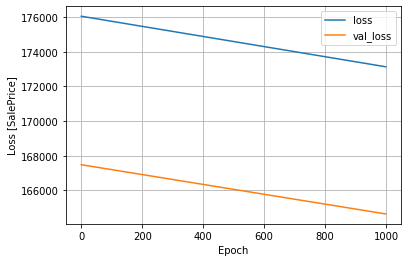

In [ ]:
plot_loss(history)

In [ ]:
validation_results = {}

validation_results['overallqual_model'] = overallqual_model.evaluate(validation_features['OverallQual'], validation_labels, verbose=0)

predictions_overallqual = overallqual_model.predict(validation_features['OverallQual'])


In [ ]:
x = tf.linspace(0.0, 0, 11)
y = overallqual_model.predict(x)


In [ ]:
def plot_overallqual(x, y):
  plt.scatter(train_features['OverallQual'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('OverallQual')
  plt.ylabel('SalePrice')
  plt.legend()

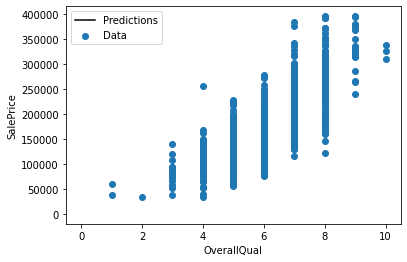

In [ ]:
plot_overallqual(x, y)

#Linear Regression with 4 inputs

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])

In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 9.7 s, sys: 362 ms, total: 10.1 s
Wall time: 13.4 s


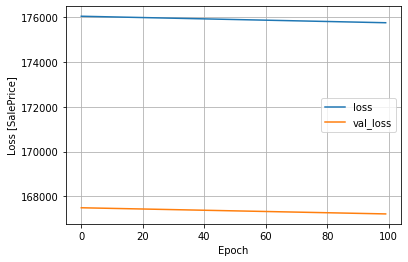

In [ ]:
plot_loss(history)

In [ ]:
validation_results['linear_model'] = linear_model.evaluate(
    validation_features, validation_labels, verbose=0)

predictions = linear_model.predict(validation_features)


#DEEP Learning Regression

#DEEP Learning Regression using only one feature

In [ ]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_overallqual_model = build_and_compile_model(overallqual_normalizer)
dnn_overallqual_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               256       
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                      

In [ ]:
%%time
history = dnn_overallqual_model.fit(
    train_features['OverallQual'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=400)

CPU times: user 44.1 s, sys: 2.77 s, total: 46.8 s
Wall time: 42.1 s


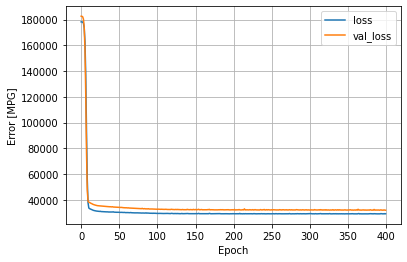

In [ ]:
plot_loss(history)

In [ ]:
validation_results['dnn_overallqual_model'] = dnn_overallqual_model.evaluate(
    validation_features['OverallQual'], validation_labels,
    verbose=0)
predictions_dnn_one_feature = dnn_overallqual_model.predict(validation_features['OverallQual'])


#DEEP Learning Regression using 4 inputs

In [ ]:
overallqual = np.array(train_features)

overallqual_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
overallqual_normalizer.adapt(overallqual)

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_7 (Dense)             (None, 128)               768       
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                      

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=600)

CPU times: user 1min 9s, sys: 4.46 s, total: 1min 13s
Wall time: 1min 22s


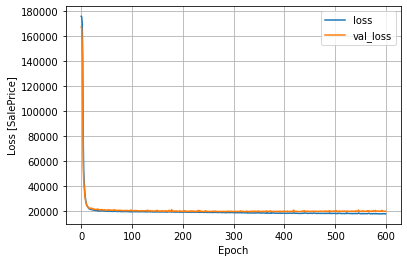

In [ ]:
plot_loss(history)

In [ ]:
validation_results['dnn_model'] = dnn_model.evaluate(validation_features, validation_labels, verbose=0)
predictions_dnn = dnn_model.predict(validation_features)


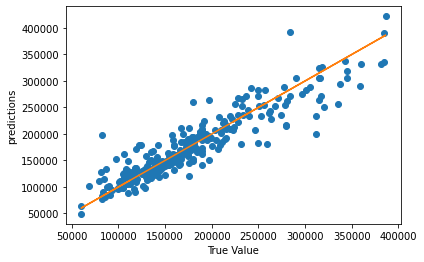

In [ ]:
x = validation_labels
y = predictions_dnn.reshape(1,-1)[0].tolist() 
plt.plot(x,y,'o')
plt.plot(x,x)
plt.xlabel('True Value')
plt.ylabel('predictions')

plt.show()


In [ ]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y,x)

0.8189049313330916

#Conclusion

In [ ]:
pd.DataFrame(validation_results, index=["Mean absolute error ['SalePrice']"]).T

,Mean absolute error ['SalePrice']
overallqual_model,174192.062500
linear_model,176782.578125
dnn_overallqual_model,26652.162109
dnn_model,18447.466797


From the table presented above the deep learning regression model with multiple inputs explaind the best the variance of the data.